# Example 8

This is a copy of Example 6 with optimal $\alpha$

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [5]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Get accuracy measures

In [6]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

  

### Standard error of autocorrelation


In [7]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [8]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [9]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


## Load the data

In [10]:
filename = "03-table-01-sales-of-saws-for-acme-tool.ods"
df = read_ods(filename, 
  {"t": "t", 
   "Sales": "Y_t"})

# add one additional row at the end of dataframe
# df.loc[len(df)] = [16, np.NaN]
num_of_quarters = 24
df_compute = df[:num_of_quarters]
df_test = df[num_of_quarters:]

df_compute

,t,Y_t
0,1,500
1,2,350
2,3,250
3,4,400
4,5,450
5,6,350
6,7,200
7,8,300
8,9,350
9,10,200


In [11]:
df_test

,t,Y_t
24,25,850
25,26,600
26,27,450
27,28,700


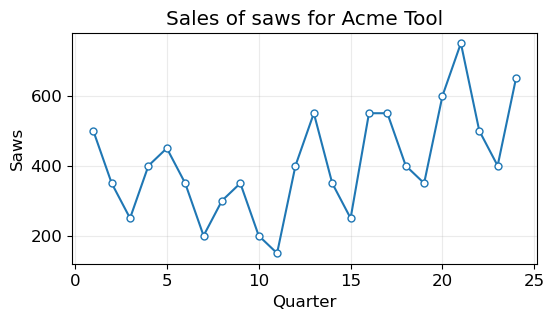

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))

# exclude the last row
ax.plot(df_compute["t"], df_compute["Y_t"], marker='o', markersize=5, 
  markerfacecolor="white")
ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Sales of saws for Acme Tool")
ax.grid("on")
plt.show(fig)


## Forecasting (exponential smoothed values)

We set that 
$$\hat{Y}_1 = \frac{1}{k} \sum^k_{t=1} Y_t$$

In [13]:
df_forecast = df_compute.copy()

# Append the first row with Y_1 to correc the initial data
# for hat_Y_t
init_hat_Y_t = (df_forecast["Y_t"][:6]).mean()
data = []
data.insert(0, {"Y_t": init_hat_Y_t})
df_forecast = pd.concat([pd.DataFrame(data), df_forecast], ignore_index=True)

alpha = 0.266357   # optimal alpha (we have to find it using gradient descent)
              # I skipped the implementation to find this optimal alpha=0.266357 
forecast_key = f"hat_Y_t_alpha_{alpha:.3f}"
residual_key = f"e_t_alpha_{alpha:.3f}"
df_forecast[forecast_key] = df_forecast["Y_t"].ewm(alpha=alpha, adjust=False).mean().shift(1)
df_forecast[residual_key] = df_forecast["Y_t"] - df_forecast[forecast_key]

df_forecast = df_forecast.drop([0]).reset_index(drop=True)

df_forecast


,Y_t,t,hat_Y_t_alpha_0.266,e_t_alpha_0.266
0,500.0,1.0,383.333333,116.666667
1,350.0,2.0,414.408317,-64.408317
2,250.0,3.0,397.252711,-147.252711
3,400.0,4.0,358.030920,41.969080
4,450.0,5.0,369.209679,80.790321
5,350.0,6.0,390.728746,-40.728746
6,200.0,7.0,379.880360,-179.880360
7,300.0,8.0,331.967967,-31.967967
8,350.0,9.0,323.453075,26.546925
9,200.0,10.0,330.524034,-130.524034


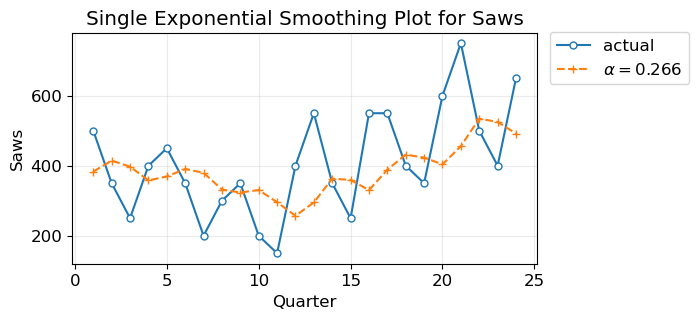

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast["t"], df_forecast["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

alpha = 0.266
forecast_key = f"hat_Y_t_alpha_{alpha:.3f}"
ax.plot(df_forecast["t"], df_forecast[forecast_key], 
  marker='+', markersize=6, linestyle='--', 
  label=r"$\alpha = $"+f"{alpha}")

ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Single Exponential Smoothing Plot for Saws")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)



### Accuracy measures

In [15]:
alpha = 0.266
forecast_key = f"hat_Y_t_alpha_{alpha:.3f}"
MAPE, _ , MSE = get_accuracy_measures(df_forecast, columns=["Y_t", forecast_key])
print(f"alpha = {alpha}")
print(f"  MSE   {MSE:>9,.0f} ")
print(f"  MAPE    {MAPE*100:>9.1f}%")

alpha = 0.266
  MSE      19,449 
  MAPE         32.2%


#### Autocorrelation function for exponential smoothing residuals ($\alpha$ = 0.266)

In [20]:
num_of_rk = 6 
alpha = 0.266
residual_key = f"e_t_alpha_{alpha:.3f}"
df_exp_smooth = df_forecast.copy()
df_exp_smooth = df_exp_smooth.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_exp_smooth, num_of_rk, columns=['t', residual_key])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.124087,0.607899,0.417742,-0.422263,0.422263
1,2,-0.585007,-2.822801,10.124709,-0.428715,0.428715
2,3,0.110512,0.413381,10.487608,-0.553029,0.553029
3,4,0.647374,2.404502,23.563296,-0.556953,0.556953
4,5,-0.004408,-0.013449,23.563934,-0.677975,0.677975
5,6,-0.538804,-1.644002,33.627996,-0.677980,0.677980


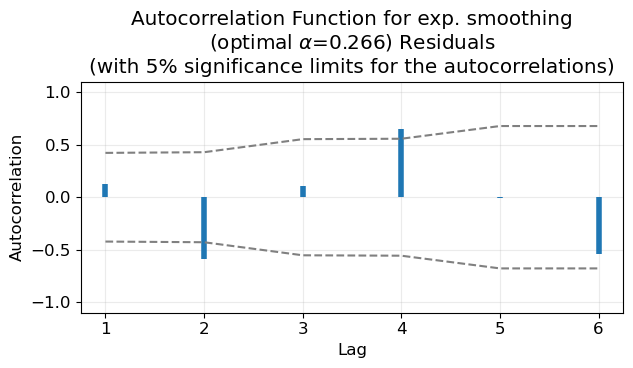

In [19]:
plot_autocorr_func(df_acorr_analysis, title="exp. smoothing\n"r"(optimal $\alpha$=0.266) Residuals")

If the forecast errors are approximately normally distributed about a mean of zero, there is about a 95% chance (if we choose significant level of 5%) that the actual observavtion will fall within two standard deviations of the forecast or within

In [25]:
RMSE = np.sqrt(MSE)

print(f"RMSE = {RMSE}")

RMSE = 139.4586532170126


In [28]:
significance_lvl = 0.05
l_bound = sc_stats.norm.ppf(significance_lvl/2)
u_bound = sc_stats.norm.ppf(1 - significance_lvl/2)

print(f"(l_bound, u_bound) = {l_bound:.2f}, {u_bound:.2f}")

(l_bound, u_bound) = -1.96, 1.96


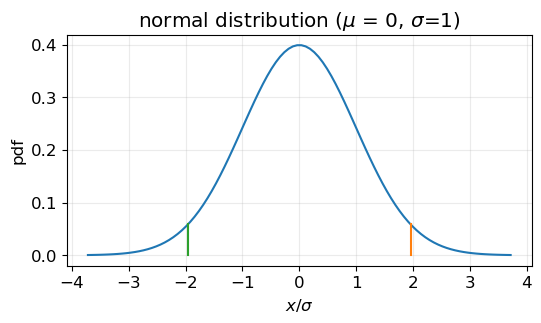

In [39]:
fig, ax = plt.subplots(figsize=(6, 3))

x = np.linspace(sc_stats.norm.ppf(0.0001),
                sc_stats.norm.ppf(0.9999), 100)
ax.plot(x, sc_stats.norm.pdf(x), label='norm')


u_bound = sc_stats.norm.ppf(significance_lvl/2)
l_bound = sc_stats.norm.ppf(1 - significance_lvl/2)
ax.plot([l_bound, l_bound], [0, sc_stats.norm.pdf(l_bound)])
ax.plot([u_bound, u_bound], [0, sc_stats.norm.pdf(u_bound)])



ax.set_xlabel(r'$x/\sigma$')
ax.set_ylabel("pdf")
ax.grid("on")
ax.set_title(r"normal distribution ($\mu$ = 0, $\sigma$=1)")

plt.show(fig)